https://data.acfr.usyd.edu.au/ag/treecrops/2016-multifruit/

https://www.kaggle.com/mbkinaci/fruit-images-for-object-detection

https://www.kaggle.com/moltean/fruits?select=fruits-360-original-size


In [ ]:
import numpy as np 
import pandas as pd 
from os.path import join, exists

 
import os
from tqdm.notebook import tqdm
import torch
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.utils.data import random_split
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline


torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



In [ ]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!chmod -R 777 "/content/gdrive/MyDrive/pdi"

^C


In [ ]:
cd /content/gdrive/MyDrive/pdi/

/content/gdrive/MyDrive/pdi


In [ ]:
ls

archive.zip*  checkpoint.tar       fruits-360-original-size/
best.tar      fruits-360_dataset/


In [ ]:
#!unzip '/content/gdrive/MyDrive/pdi/archive.zip' 

In [ ]:
data_dir_train = 'fruits-360_dataset/fruits-360/Training'
data_dir_test = 'fruits-360_dataset/fruits-360/Test'


In [ ]:
!ls

archive.zip  checkpoint.tar	 fruits-360-original-size
best.tar     fruits-360_dataset


In [ ]:
size_pictures = 100
data_transforms = transforms.Compose([transforms.Resize((size_pictures, size_pictures)),
                                 transforms.ToTensor()])


In [ ]:
dataset = ImageFolder(root=data_dir_train,transform=data_transforms)
data_test = ImageFolder(root=data_dir_test,transform=data_transforms)
print(len(dataset), len(data_test))


67692 22688


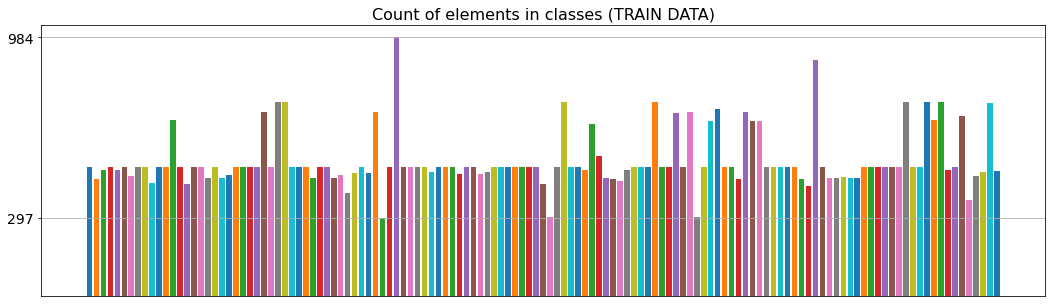

In [ ]:
#Show data balance in train
labels_count = {}
for image in dataset.imgs:
    label = image[1]
    if label not in labels_count.keys():
        labels_count[label] = 0
    labels_count[label] += 1
class_counts = labels_count.copy()

#Visualize
plt.figure(figsize=(18, 5));
for n,key in enumerate(labels_count):
    plt.bar(list(labels_count.keys())[n],
            list(labels_count.values())[n]);     
plt.title('Count of elements in classes (TRAIN DATA)', fontsize=16)
plt.xticks([]);
plt.grid()
plt.yticks((min(list(labels_count.values())), max(list(labels_count.values()))), fontsize=14);


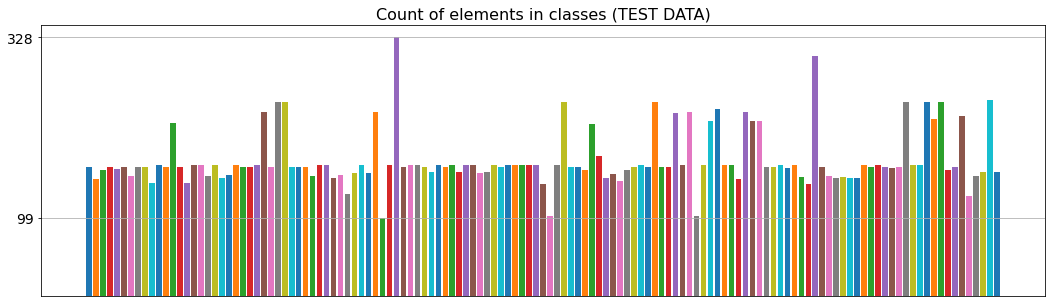

In [ ]:
#Show data balance in test
labels_count = {}
for image in data_test.imgs:
    label = image[1]
    if label not in labels_count.keys():
        labels_count[label] = 0
    labels_count[label] += 1
class_counts = labels_count.copy()

#Visualize
plt.figure(figsize=(18, 5));
for n,key in enumerate(labels_count):
    plt.bar(list(labels_count.keys())[n],
            list(labels_count.values())[n]);     
plt.title('Count of elements in classes (TEST DATA)', fontsize=16)
plt.xticks([]);
plt.grid()
plt.yticks((min(list(labels_count.values())), max(list(labels_count.values()))), fontsize=14);

In [ ]:
def show_random_image():
    index = np.random.randint(0,len(dataset))
    return dataset[index]

In [ ]:
img, label = show_random_image()

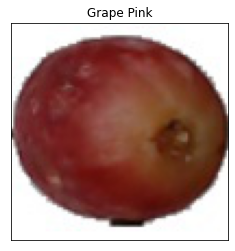

In [ ]:
img, label = show_random_image()
plt.title(dataset.classes[label])
plt.imshow(img.permute(1, 2, 0));
plt.xticks([]);
plt.yticks([]);


In [ ]:
fig = plt.figure(figsize=(15,15));
for i in range(1,11):
    plt.subplot(1,10, i,)
#     plt.title(dataset.classes[label])
    img, label = show_random_image()
    plt.imshow(img.permute(1, 2, 0));
    plt.xticks([]);
    plt.yticks([]);


In [ ]:
train_size = int(0.8 * len(dataset)) 
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds) # train_ds length = dataset length - val_ds length

(54153, 13539)

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        #Primeira camada por convolução
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=7, kernel_size=3, padding=1)
        #Função de ativação por ReLU
        self.act1 = nn.ReLU()
        #Poolar pelas medias
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        
        #Segunda camada por convolução
        self.conv2 = nn.Conv2d(in_channels=7, out_channels=10, kernel_size=5, padding=2)
        #Função de ativação por ReLU
        self.act2 = nn.ReLU()
        #Poolar pelas medias
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        
        #Aplicar primeira camada linear
        #6250
        self.fc1 = nn.Linear(6250,  1048)
        #Função de ativação por ReLU
        self.act3 = nn.ReLU()
        
        #Aplicar segunda camada linea
        self.fc2 = nn.Linear(1048, 262)
        #Função de ativação por Sigmoide
        self.act4 = nn.Sigmoid()
        
        #Aplicar terceira camada linear
        self.fc3 = nn.Linear(262, 131)
        
    #Função de Feed-Forward (definir ordem das camadas)
    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)  
        
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act3(x)
        
        x = self.fc2(x)
        x = self.act4(x)
        
        x = self.fc3(x)
        return x

In [ ]:
#Definindo model e carregando p GPU
model = NeuralNetwork()
model = model.to(device)
#Definindo metodo de loss por entropia cruzada
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),  lr = 10 **(-3))
#No de epocas
epoch = 10
#Tam do batch
batch_size = 256
#Carregando os datasets
dataloader = DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(dataset=val_ds, batch_size=batch_size)

reload_file = 'best.tar'
reload_flag = False
if exists(reload_file) and reload_flag:
    print("loaded")
    state = torch.load(reload_file)
    model.load_state_dict(state['state_dict'])

In [ ]:
from os.path import join, exists
from os import mkdir

def save_checkpoint(state, is_best, filename, best_filename):
    """ Save state in filename. Also save in best_filename if is_best. """
    torch.save(state, filename)
    if is_best:
        torch.save(state, best_filename)

acc = []
loss_array = []
def training(model, batch_size, epochs, loss, optimizer):
    cur_best = None

    for epoch in range(1, epochs + 1):
        model.train()
        for (X_batch,y_batch) in tqdm(dataloader): 
            optimizer.zero_grad()
            
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            preds = model.forward(X_batch)
            
            loss_value = loss(preds, y_batch.long())
            loss_array.append(loss_value.item())
            loss_value.backward()
            
            optimizer.step()

        model.eval()
        with torch.no_grad():
            summa = 0
            for (X_batch,y_batch) in tqdm(dataloader_test):
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                preds = model.forward(X_batch)
                preds = torch.max(F.softmax(preds, dim=1), dim=1)
                correct= torch.eq(preds[1], y_batch)
                summa += torch.sum(correct).item()

            acc.append(summa / len(val_ds))
            print(f'epoch: {epoch}, acc:{acc[-1]:.2%}')
        
        best_filename = 'best.tar'
        filename = 'checkpoint.tar'
        is_best = not cur_best or acc[-1] < cur_best
        if is_best:
            cur_best = acc[-1]
        save_checkpoint({
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'precision': acc[-1],
            'optimizer': optimizer.state_dict(),
        }, is_best, filename, best_filename)


In [ ]:
%%time
training(model, batch_size, epoch, loss, optimizer)

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

epoch: 1, acc:82.50%


  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

epoch: 2, acc:96.72%


  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

epoch: 3, acc:99.19%


  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

epoch: 4, acc:99.28%


  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

epoch: 5, acc:99.90%


  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

epoch: 6, acc:99.80%


  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

epoch: 7, acc:99.89%


  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

epoch: 8, acc:99.92%


  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

epoch: 9, acc:99.93%


  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

epoch: 10, acc:99.90%
CPU times: user 52min 14s, sys: 3min 26s, total: 55min 40s
Wall time: 1h 8min 3s


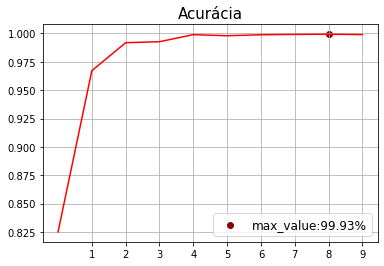

In [ ]:
acc_max = max(acc)
y_acc_max = acc.index(max(acc))
plt.title('Acurácia', fontsize = 15 );
plt.xticks(np.arange(1, epoch));
plt.scatter( y_acc_max, acc_max, color='darkred', label = f'max_value:{acc_max:.2%}');
plt.plot(acc, color='red', );
plt.grid()
plt.legend(fontsize = 12);


2120
[2.5041587504575835, 0.6025293251534678, 0.18387550171816125, 0.07512901361399102, 0.04175464746559847, 0.03775751016120303, 0.018082882339169958, 0.013516985389562149, 0.06373039966466713, 0.012118353471072074]


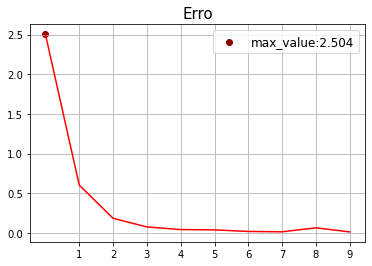

In [ ]:

loss_array = np.array(loss_array)
print(len(loss_array))
soma = []
for i in range(10):
    soma.append(np.sum(loss_array[i*212:(i+1)*212])/212)
loss_max = max(soma)
print(soma)
y_loss_max = soma.index(max(soma))
plt.title('Erro', fontsize = 15 );
plt.xticks(np.arange(1, len(soma)));
plt.scatter( y_loss_max, loss_max, color='darkred', label = f'max_value:{loss_max:.4}');
plt.plot(soma, color='red', );
plt.grid()
plt.legend(fontsize = 12);

tensor([48, 89, 17, 60, 25, 43])


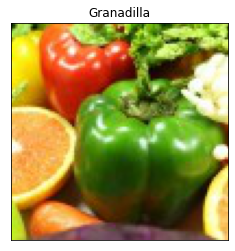

In [ ]:
import torchvision.io
from torchvision import transforms

val_1 = torchvision.io.read_image('/content/gdrive/MyDrive/pdi/validation/Banana_validation.jpg')
val_2 = torchvision.io.read_image('/content/gdrive/MyDrive/pdi/validation/apple_validation.jpg')
val_3 = torchvision.io.read_image('/content/gdrive/MyDrive/pdi/validation/cherry_validation.jpeg')
val_4 = torchvision.io.read_image('/content/gdrive/MyDrive/pdi/validation/orange_validation.jpeg')
val_5 = torchvision.io.read_image('/content/gdrive/MyDrive/pdi/validation/pacman_validation.jpg')
val_6 = torchvision.io.read_image('/content/gdrive/MyDrive/pdi/validation/pimentao_validation.jpg')

dataset_val = torch.stack([val_1,val_2,val_3,val_4,val_5,val_6])/255

dataloader_val = DataLoader(dataset=dataset_val,batch_size=6)

val_batch = next(iter(dataloader_val))
preds_val = model.forward(val_batch)
preds_val = torch.max(F.softmax(preds_val, dim=1), dim=1)

print(preds_val.indices)
plt.title(dataset.classes[preds_val.indices[5]])
a = plt.imread('/content/gdrive/MyDrive/pdi/validation/pimentao_validation.jpg')
plt.imshow(a);
plt.xticks([]);
plt.yticks([]);

In [ ]:
dataloader_test = DataLoader(dataset=data_test, batch_size=256)
summa = 0
y_true = []
y_pred = []
for (X_batch,y_batch) in tqdm(dataloader_test):
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
    preds = model.forward(X_batch)
    val_predict_class = preds.argmax(dim=-1)

    y_pred.extend([predict_class.item() for predict_class in val_predict_class])
    y_true.extend([val_label.item() for val_label in y_batch])


  0%|          | 0/89 [00:00<?, ?it/s]

In [ ]:
cl_report = classification_report(y_true, y_pred,output_dict=True,
                               target_names=dataset.classes)


In [ ]:
report_df = pd.DataFrame(cl_report).T.sort_values(by=['precision', 'recall', 'f1-score'], ascending=False)
report_df.drop(['support'], axis=1, inplace=True)
report_df


In [ ]:
max_values = report_df.head(20)
min_values = report_df.tail(20)

plt.figure(figsize=(17, 5))


plt.subplot(1, 2, 1);
plt.title('Precision_max');
max_values['precision'].plot.bar();

plt.subplot(1, 2, 2);
plt.title('Precision_min');
min_values['precision'].plot.bar();

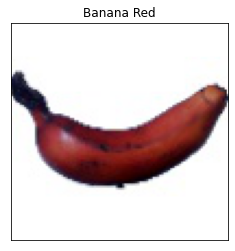

In [ ]:


dataloader_test = DataLoader(dataset=data_test, batch_size=1,shuffle=True)
test_batch = next(iter(dataloader_test))
test_image, _ = test_batch
preds_val = model.forward(test_image)
preds_val = torch.max(F.softmax(preds_val, dim=1), dim=1)

plt.title(dataset.classes[preds_val[1]])
plt.imshow(test_image[0].permute(1, 2, 0));
plt.xticks([]);
plt.yticks([]);

In [ ]:
!pip3 install shap

In [ ]:
import shap

In [ ]:
batch = next(iter(dataloader_test))
images, _ = batch

background = images[:100].to(device)
test_images = images[100:105].to(device)

e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.cpu().numpy(), 1, -1), 1, 2)
shap.image_plot(shap_numpy, -test_numpy)